Model loaded successfully!
Test samples: 5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


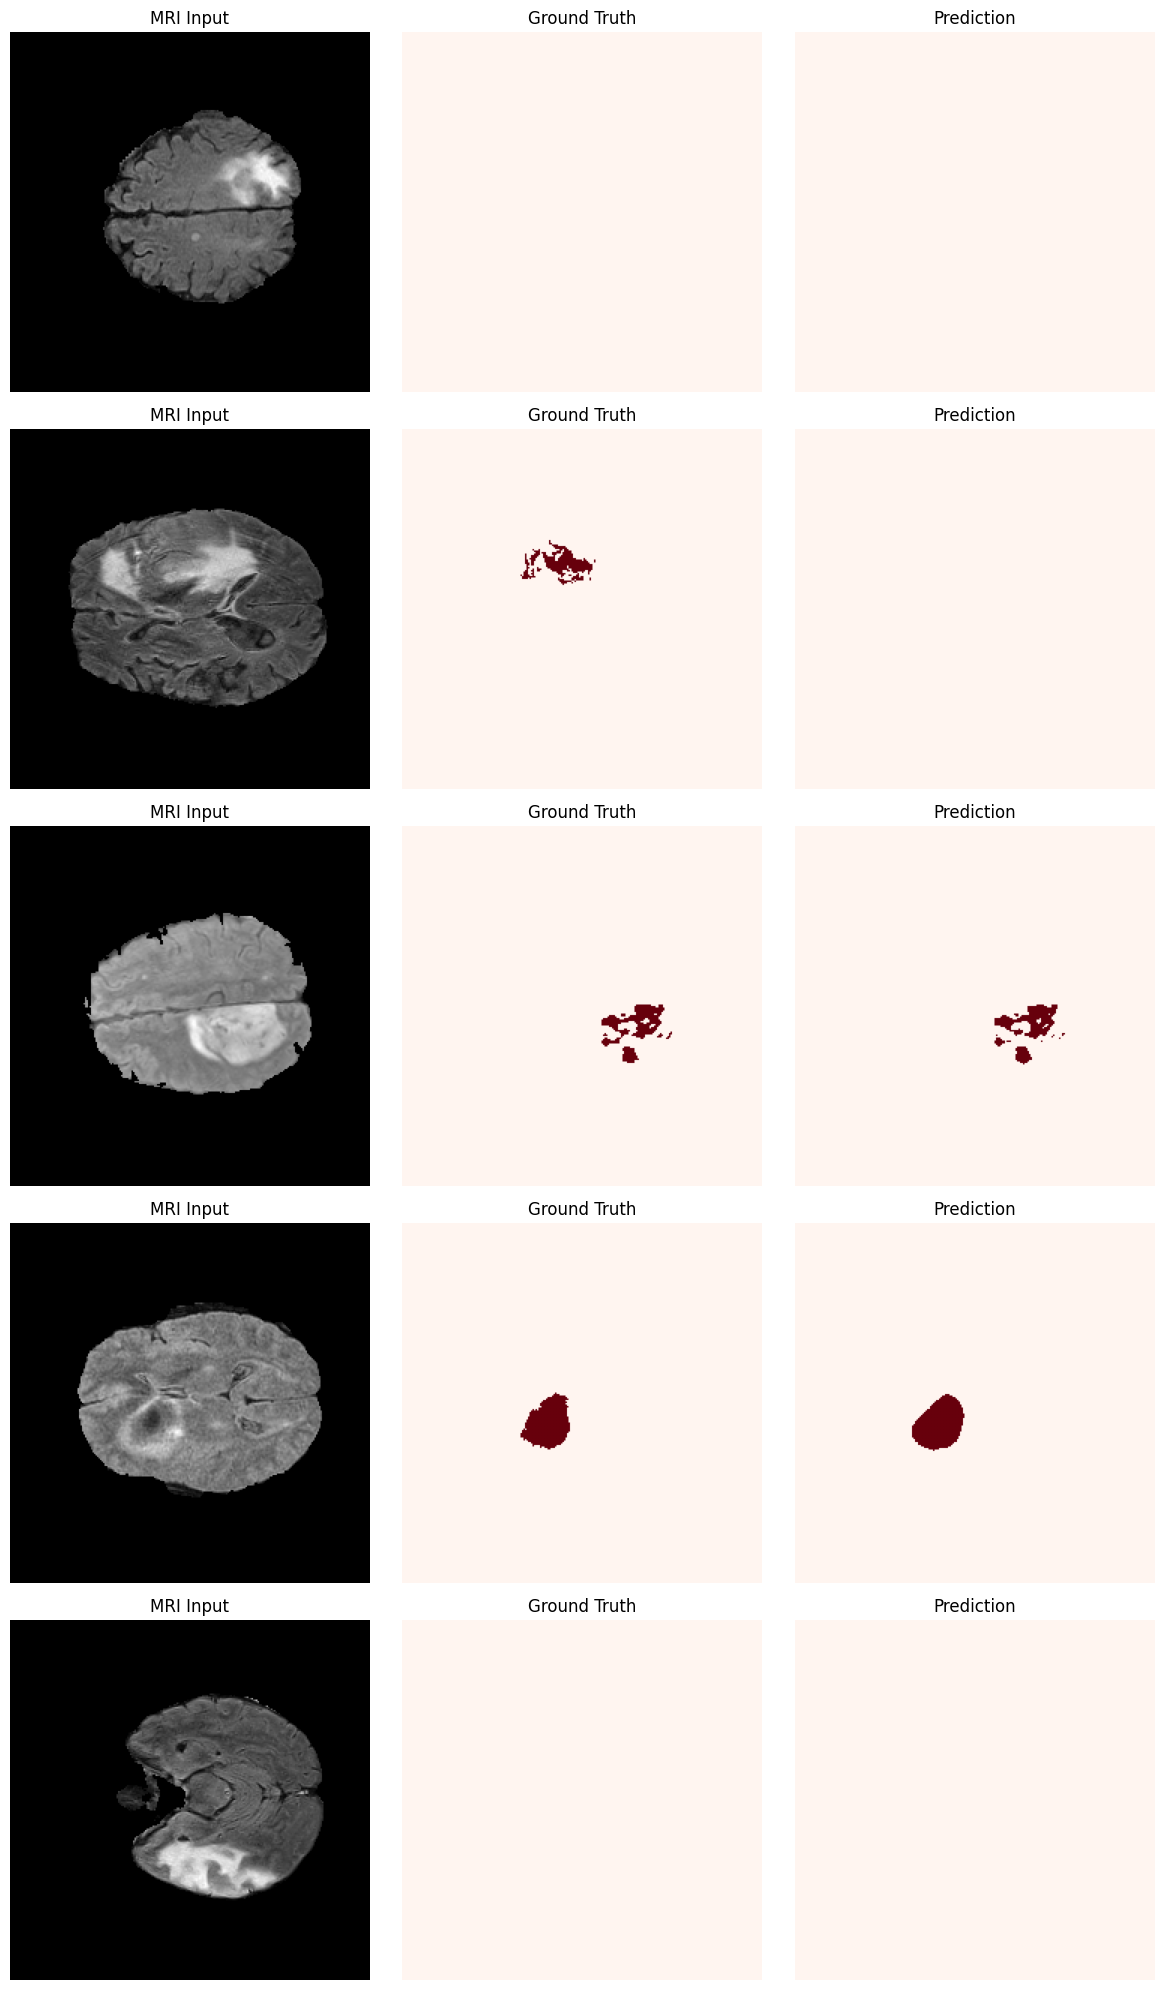

Sample 1 Dice: 0.949
Sample 2 Dice: 0.673
Sample 3 Dice: 0.925
Sample 4 Dice: 0.878
Sample 5 Dice: 0.959

Mean Dice Score: 0.877


In [6]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob

# 1. Define loss functions (needed to load model)
def dice_coef(y_true, y_pred, smooth=1e-5):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = alpha * tf.pow(1 - p_t, gamma)
    return tf.reduce_mean(focal_weight * bce)

def combined_focal_dice(y_true, y_pred):
    return focal_loss(y_true, y_pred, alpha=0.25, gamma=0.2) + dice_loss(y_true, y_pred)

# 2. Load model
model = tf.keras.models.load_model('best_so_far_model.h5', 
    custom_objects={
        'dice_coef': dice_coef, 
        'combined_focal_dice': combined_focal_dice
    })

print("Model loaded successfully!")

# 3. Load some test data
data_dir = './data/BraTS/BraTS2020_training_data/content/data'
test_files = glob.glob(f'{data_dir}/*.h5')[-20:]  # Last 20 files as test

test_images = []
test_masks = []

for file_path in test_files[:10]:  # Load 10 samples
    with h5py.File(file_path, 'r') as f:
        image = f['image'][:]
        mask = f['mask'][:]
        
        if np.sum(mask > 0) > 100:
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            mask = (mask > 0).astype(np.float32)
            
            test_images.append(image)
            test_masks.append(mask)

test_images = np.array(test_images)
test_masks = np.array(test_masks)

print(f"Test samples: {len(test_images)}")

# 4. Make predictions
predictions = model.predict(test_images)

# 5. Visualize results
fig, axes = plt.subplots(len(test_images), 3, figsize=(12, 4*len(test_images)))

for i in range(len(test_images)):
    # MRI input
    axes[i, 0].imshow(test_images[i, :, :, 0], cmap='gray')
    axes[i, 0].set_title('MRI Input')
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(test_masks[i, :, :, 0], cmap='Reds')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    # Prediction
    axes[i, 2].imshow(predictions[i, :, :, 0] > 0.2, cmap='Reds')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# 6. Calculate Dice scores
dice_scores = []
for i in range(len(test_images)):
    dice = dice_coef(test_masks[i], predictions[i]).numpy()
    dice_scores.append(dice)
    print(f"Sample {i+1} Dice: {dice:.3f}")

print(f"\nMean Dice Score: {np.mean(dice_scores):.3f}")